# Using data to decide where to open a new coffee shop

## Analysis based on Helsinki capital region open data

![Coffee shop](jazmin-quaynor-9Y8vxVQN4o4-unsplash_s.png)


## Introduction
Good Coffee Company Ltd has decided to expand to the Helsinki capital region. One question remains: Which neighborhood would be a good location for the new coffee shop?

To provide some basis for this decision, let's analyze some data about the Helsinki capital region. We would like to see some data about the economic situation in the neighborhoods, and also would like to include some analysis of the existing offering of cafés in the area.

Helsinki capital region is an area which contains the cities of Vantaa, Espoo and Kauniainen, in addition to the capital of Finland: Helsinki. There are approximately 1.19 million inhabitants in the Helsinki capital region.

The aim of this study is to help the stakeholders of this imaginary coffee company to decide where to open a new cafe in the helsinki metropolitan region. The company does not previously have a cafe in Helsinki.

This study/notebook could also be used as a starting point for any other futher analysis of Helsinki region data.

### Map of Helsinki metropolitan area

![Map Helsinki metropolitan area](helsinki_capital_region.PNG)

## Data

Data from several sources will be combined for this analysis. The main data sources will be the statistics institute of Finland (stat.fi), and the helsinki region infoshare site (hri.fi). Foursquare places API (https://developer.foursquare.com/docs/places-api/) will also be used to get data about the different venues around the region.

### Map data
The map data about the postal areas can be fetched from here: https://hri.fi/data/fi/dataset//paakaupunkiseudun-postinumeroalueet

The map data was in KML format and was converted to GeoJSON format using python package "kml2geojson".

### Economics data

The main economics data about the region can be fetched from here.

https://pxnet2.stat.fi/PXWeb/pxweb/fi/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2021/paavo_pxt_12f7.px/

One challenge is that the coordinate data about the postal code areas is in EUREF-FIN -format. This data has to be converted to the international WGS84 coordinate system so that it can be fed to the Foursquare API. For this conversion I will be using python package "pyproj".

We will use the economics data to clearly define what kind of population lives in the different areas, and what kind of buying power they have. We will also try to look into the amount of offices and businesses versus homes, hypothesis being that if there are offices nearby maybe the workers would use the cafe during the office hours.

### The venue data

For the venue data we will be using Foursquare API (https://developer.foursquare.com/docs/places-api/). The venue data will help to establish knowledge of the existing competition and other venues as well. To match the venue data to the postal code areas we would need the coordinates for the approximate center of each postal code.

## Analysis


In [1]:
# import needed dependencies
import numpy as np
import pandas as pd
import folium
import json
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
# Let's get the general postal area data into a dataframe
# This CSV file has been manually downloaded from Statistics Finland, from this URL: https://pxnet2.stat.fi/PXWeb/pxweb/fi/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2021/paavo_pxt_12f7.px/
postalareas_df = pd.read_csv("009_12f7_2021.csv",skiprows=2, encoding='ansi')

# The source data field 'Postinumeroalue' contains both the postal code and the area name.
# So let's split it into two separate fields
postalareas_df[['Postalcode','Areaname']] = postalareas_df.Postinumeroalue.str.split(" ", n=1,expand=True)

# We can drop the old 'Postinumeroalue' column
postalareas_df = postalareas_df.drop('Postinumeroalue',axis=1)

# Strip the city name from the areanames
postalareas_df['Areaname'] = postalareas_df['Areaname'].map(lambda x: x.replace(' (Helsinki)','').replace(' (Vantaa)','').replace(' (Espoo)','').replace(' (Kauniainen)',''))

# Some rows have '...' to protect anonymity when there is not enough data. Let's just replace those with zeroes for now.
postalareas_df = postalareas_df.replace('...', 0)

# Convert some fields to integers
postalareas_df = postalareas_df.astype({'Opiskelijat, 2018 (PT)': int, 'Eläkeläiset, 2018 (PT)': int, 'Lapset 0-14 -vuotiaat, 2018 (PT)': int })

# Show some results
postalareas_df[['Postalcode','Areaname','X-koordinaatti metreinä','Y-koordinaatti metreinä','Postinumeroalueen pinta-ala','Asukkaat yhteensä, 2019 (HE)','Asukkaiden keski-ikä, 2019 (HE)','Ylemmän korkeakoulututkinnon suorittaneet, 2019 (KO)']].head()

Postalcode                        Areaname  X-koordinaatti metreinä  \
0      00100   Helsinki Keskusta - Etu-Töölö                   384979   
1      00120                       Punavuori                   385531   
2      00130                 Kaartinkaupunki                   386244   
3      00140        Kaivopuisto - Ullanlinna                   386394   
4      00150               Eira - Hernesaari                   385320   

   Y-koordinaatti metreinä  Postinumeroalueen pinta-ala  \
0                  6672361                      2353278   
1                  6671434                       414010   
2                  6671474                       428960   
3                  6670766                       931841   
4                  6670373                      1367328   

   Asukkaat yhteensä, 2019 (HE)  Asukkaiden keski-ikä, 2019 (HE)  \
0                         18334                               41   
1                          7140                               41   
2                          1582                               41   
3                          7958                               42   
4                          9420                               40   

   Ylemmän korkeakoulututkinnon suorittaneet, 2019 (KO)  
0                                               6036     
1                                               2250     
2                                                530     
3                                               2548     
4                                               2855

In [3]:
# How many many postal code areas are there?
print("Count of postal code areas is {}".format(postalareas_df.shape[0]))

Count of postal code areas is 168


### Let's chart some simple statistics about the postal code areas

In [4]:
# Let's calculate the density
postalareas_df['PopulationPerSquareKm'] = postalareas_df["Asukkaat yhteensä, 2019 (HE)"] / ( postalareas_df["Postinumeroalueen pinta-ala"] / 1000000 )

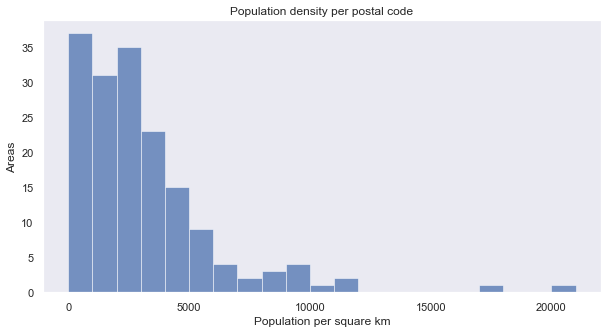

In [5]:
# And plot population density histogram
sns.set_theme(style="dark")
fig, ax = plt.subplots(figsize=(10,5))

# Seaborn histogram plot, main parameters are 'data' and 'x'
pop_chart = sns.histplot(
    ax = ax,
    x="PopulationPerSquareKm",
    data=postalareas_df,
    bins=20,
    binwidth=1000,
    linewidth=.5
)
pop_chart.set_title('Population density per postal code')
plt.xlabel("Population per square km")
plt.ylabel("Areas")
plt.show()

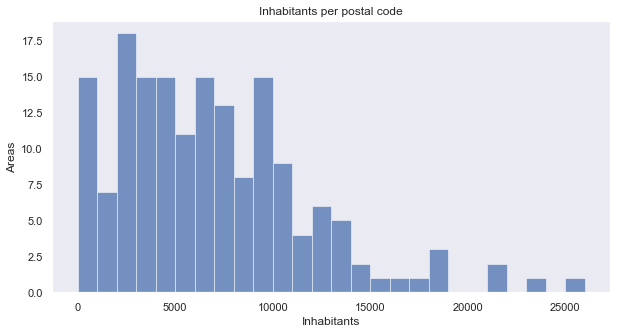

In [6]:
# Let's plot histogram of total inhabitants per postal code area
sns.set_theme(style="dark")
fig, ax = plt.subplots(figsize=(10,5))

# Seaborn histogram plot, main parameters are 'data' and 'x'
pop_chart = sns.histplot(
    ax = ax,
    x="Asukkaat yhteensä, 2019 (HE)",
    data=postalareas_df,
    bins=20,
    binwidth=1000,
    linewidth=.5
)
pop_chart.set_title('Inhabitants per postal code')
plt.xlabel("Inhabitants")
plt.ylabel("Areas")
plt.show()

So most postal code areas are between 0 and 10000 inhabitants, with some areas going up to 25000 inhabitants.

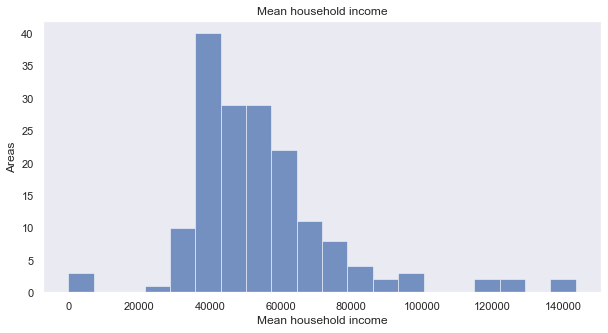

In [7]:
# Let's see the mean income distribution

fig, ax = plt.subplots(figsize=(10,5))

# Seaborn histogram plot, main parameters are 'data' and 'x'
pop_chart = sns.histplot(
    x="Talouksien keskitulot, 2019 (TR)",
    data=postalareas_df,
    bins=20,
    linewidth=.5
)
pop_chart.set_title('Mean household income')
plt.xlabel("Mean household income")
plt.ylabel("Areas")
plt.show()


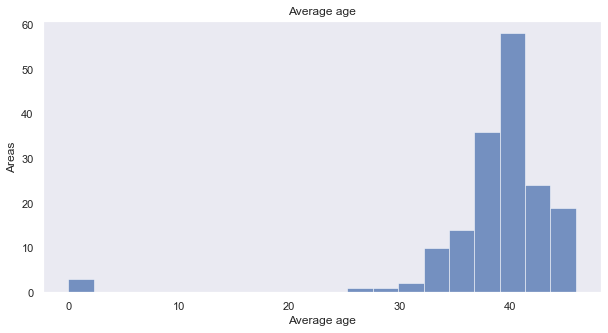

In [8]:
# Let's see the distribution of average ages

fig, ax = plt.subplots(figsize=(10,5))

# Seaborn histogram plot, main parameters are 'data' and 'x'
pop_chart = sns.histplot(
    x="Asukkaiden keski-ikä, 2019 (HE)",
    data=postalareas_df,
    bins=20,
    linewidth=.5
)
pop_chart.set_title('Average age')
plt.xlabel("Average age")
plt.ylabel("Areas")
plt.show()

In [9]:
# Before mapping we need the latitude and longitude for postal code areas, so let's transform those now using pyproj module
from pyproj import CRS
from pyproj import Transformer

# This is the target coordinate system that Foursquare understands
crs_4326 = CRS("WGS84")

# The source data is in this coordinate system
etrs_fin = CRS("ETRS89 / TM35FIN(E,N)")

# Create a transformer between source and target coordinate systems
transformer = Transformer.from_crs(etrs_fin, crs_4326)

latitudes = []
longitudes = []

# Transform each row in the dataframe separately
for i, row in postalareas_df.iterrows():

    # These variables are the source coordinates in ETRS89 coordinate system
    xx = row['X-koordinaatti metreinä']
    yy = row['Y-koordinaatti metreinä']

    res = transformer.transform(xx, yy)

    # res contains now the coordinates in the WGS84 coordinate system
    latitudes.append(res[0])
    longitudes.append(res[1])

# Add the transformed data back to the dataframe
postalareas_df['latitude'] = latitudes
postalareas_df['longitude'] = longitudes
postalareas_df[['Postalcode','latitude','longitude']].head()

postalareas_df[postalareas_df['Postalcode']=='00510']
# So now we have nice data of the location of each postal code, ready to be used as a source in mapping

X-koordinaatti metreinä  Y-koordinaatti metreinä  \
35                   386306                  6674580   

    Postinumeroalueen pinta-ala  Asukkaat yhteensä, 2019 (HE)  \
35                      1062161                          9814   

    Miehet, 2019 (HE)  Naiset, 2019 (HE)  Asukkaiden keski-ikä, 2019 (HE)  \
35               4707               5107                               39   

    0-2-vuotiaat, 2019 (HE)  3-6-vuotiaat, 2019 (HE)  \
35                      255                      220   

    7-12-vuotiaat, 2019 (HE)  ...  Työttömät, 2018 (PT)  \
35                       204  ...                   555   

    Lapset 0-14 -vuotiaat, 2018 (PT)  Opiskelijat, 2018 (PT)  \
35                               679                     511   

    Eläkeläiset, 2018 (PT)  Muut, 2018 (PT)  Postalcode  \
35                    1423              346       00510   

                  Areaname  PopulationPerSquareKm   latitude  longitude  
35   Etu-Vallila - Alppila            9239.653875  60.192183  24.949534  

[1 rows x 111 columns]

### Let's see the postal code areas on map

In [10]:
# Helsinki center
helsinki_latitude = 60.192059
helsinki_longitude = 24.945831

areas_geo = r'PKS_Postinumeroalueet_manner_2019.json'

map_helsinki = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11.5,tiles="cartodbpositron")

# Let's create a Folium Chropleth map
map_helsinki.choropleth(
    geo_data=areas_geo,
    key_on='feature.properties.name',
    fill_color='YlGn', 
    fill_opacity=0.0, 
    line_opacity=0.6,
    legend_name='Postal code areas',
    smooth_factor=0,
    reset=True
    )

# Let's add some data to the map as markers
for i, row in postalareas_df.iterrows():
    folium.Marker([row['latitude'],row['longitude']], popup="" + row['Postalcode'] + " " +row['Areaname'] + " " + str(row['latitude']) + "," + str(row['longitude']) ).add_to(map_helsinki)

# Show the map
map_helsinki

Let's classify the areas by clustering


In [11]:
#
# Let's create first some variables for the clustering
#

postalareas_cluster_df = postalareas_df[["Postalcode","Talouksien keskitulot, 2019 (TR)","Työpaikat yhteensä, 2018 (TP)"]]
postalareas_cluster_df['PopulationPerSquareKm'] = postalareas_df["Asukkaat yhteensä, 2019 (HE)"] / ( postalareas_df["Postinumeroalueen pinta-ala"] / 1000000 )

# Average age of the population
postalareas_cluster_df['PopulationAge'] = postalareas_df["Asukkaiden keski-ikä, 2019 (HE)"]
postalareas_cluster_df['PopulationAge'] = postalareas_cluster_df['PopulationAge'].fillna(0)

# What proportion are students out of the whole population?
postalareas_cluster_df['Students'] = postalareas_df["Opiskelijat, 2018 (PT)"] / postalareas_df["Asukkaat yhteensä, 2018 (PT)"]
postalareas_cluster_df['Students'] = postalareas_cluster_df['Students'].fillna(0)

# What proportion are pensioners out of the whole population?
postalareas_cluster_df['Pensioners'] = postalareas_df["Eläkeläiset, 2018 (PT)"] / postalareas_df["Asukkaat yhteensä, 2018 (PT)"]
postalareas_cluster_df['Pensioners'] = postalareas_cluster_df['Pensioners'].fillna(0)

# What proportion are children out of the whole population?
postalareas_cluster_df['Children'] = postalareas_df["Lapset 0-14 -vuotiaat, 2018 (PT)"] / postalareas_df["Asukkaat yhteensä, 2018 (PT)"]
postalareas_cluster_df['Children'] = postalareas_cluster_df['Children'].fillna(0)

# Jobs in hotels and restaurants as a fraction of all jobs (maybe this is a proxy for hotel and accommodation activity)
postalareas_cluster_df['Hospitality'] = postalareas_df["I Majoitus- ja ravitsemistoiminta, 2018 (TP)"] / postalareas_df["Työpaikat yhteensä, 2018 (TP)"]
postalareas_cluster_df['Hospitality'] = postalareas_cluster_df['Hospitality'].fillna(0)

#  Which proportion of people have higher university education
postalareas_cluster_df['UniversityDegrees'] =  postalareas_df["Ylemmän korkeakoulututkinnon suorittaneet, 2019 (KO)"] / postalareas_df["Asukkaat yhteensä, 2019 (HE)"]
# fill NaN's with 0's
postalareas_cluster_df['UniversityDegrees'] = postalareas_cluster_df['UniversityDegrees'].fillna(0)

postalareas_cluster_df = postalareas_cluster_df.drop(labels='Postalcode',axis=1)

# Normalize data before feeding it to the k-means
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
postalareas_standardized_df = pd.DataFrame(scaler.fit_transform(postalareas_cluster_df), columns = postalareas_cluster_df.columns)
#postalareas_standardized_df


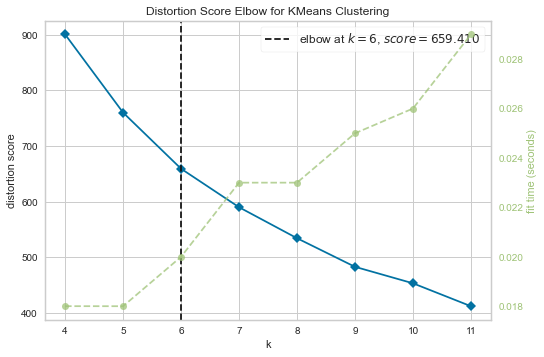

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(postalareas_standardized_df)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [13]:
# Set the cluster number
kclusters = 7

# Train k-means clustering model
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(postalareas_standardized_df)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([4, 6, 6, 6, 6, 6, 6, 4, 0, 6, 6, 6, 3, 4, 6, 6, 6, 1, 4, 1])

In [14]:
# add the labels from k-means back to the dataframe
postalareas_cluster_df.insert(0, 'EconomicAreaLabel', kmeans.labels_)
postalareas_cluster_grouped_df = postalareas_cluster_df.groupby(by='EconomicAreaLabel').mean()
postalareas_cluster_grouped_df

Talouksien keskitulot, 2019 (TR)  \
EconomicAreaLabel                                     
0                                      59617.111111   
1                                      45015.620253   
2                                      23036.000000   
3                                          0.000000   
4                                      46104.200000   
5                                      98366.625000   
6                                      57713.739130   

                   Työpaikat yhteensä, 2018 (TP)  PopulationPerSquareKm  \
EconomicAreaLabel                                                         
0                                    1394.472222            1289.693342   
1                                    2566.430380            2892.360958   
2                                   19460.000000            2056.591200   
3                                    1091.666667               0.000000   
4                                   20338.300000            4017.272906   
5                                    1012.312500            1644.548220   
6                                    4592.217391            7512.541527   

                   PopulationAge  Students  Pensioners  Children  Hospitality  \
EconomicAreaLabel                                                               
0                      35.944444  0.074472    0.125495  0.227615     0.042949   
1                      40.860759  0.069567    0.208645  0.156533     0.033329   
2                      27.000000  0.357962    0.022139  0.032542     0.016238   
3                       0.000000  0.000000    0.000000  0.000000     0.003026   
4                      38.900000  0.059893    0.157348  0.126960     0.037356   
5                      41.625000  0.079238    0.204530  0.188793     0.028255   
6                      40.782609  0.064256    0.195428  0.119361     0.087638   

                   UniversityDegrees  
EconomicAreaLabel                     
0                           0.155322  
1                           0.133937  
2                           0.170388  
3                           0.000000  
4                           0.196474  
5                           0.274591  
6                           0.272504

## Figuring out the properties of each postal code area

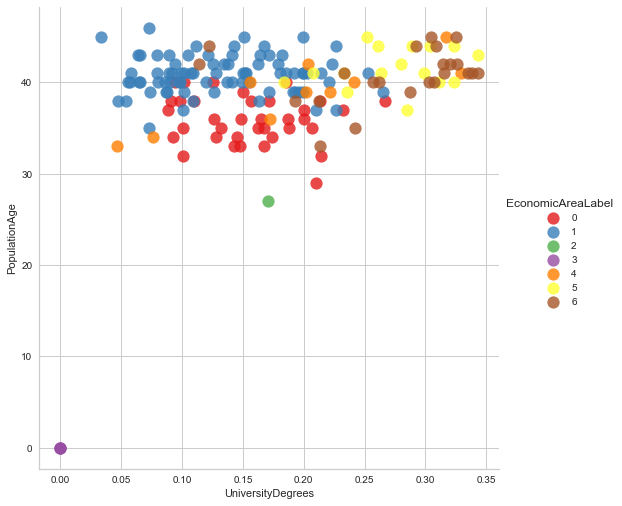

In [15]:
# Plot university degrees vs. population age

import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("Set1", 7)
facet = sns.lmplot(height=7, aspect=1.0,data=postalareas_cluster_df, x='UniversityDegrees', y='PopulationAge', hue='EconomicAreaLabel', scatter_kws={"s": 150}, fit_reg=False, legend=True, legend_out=True,palette=palette)


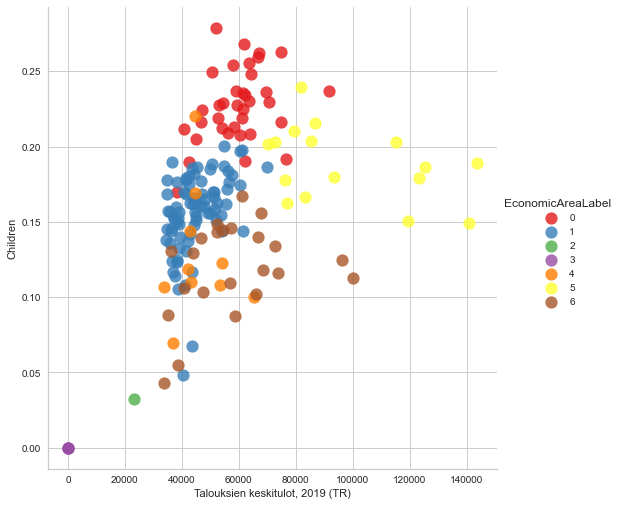

In [16]:
# Plot household mean income vs. count of children in the postal code area

facet = sns.lmplot(height=7, aspect=1.0,data=postalareas_cluster_df, x='Talouksien keskitulot, 2019 (TR)', y='Children', hue='EconomicAreaLabel',scatter_kws={"s": 150}, fit_reg=False, legend=True, legend_out=True, palette=palette)

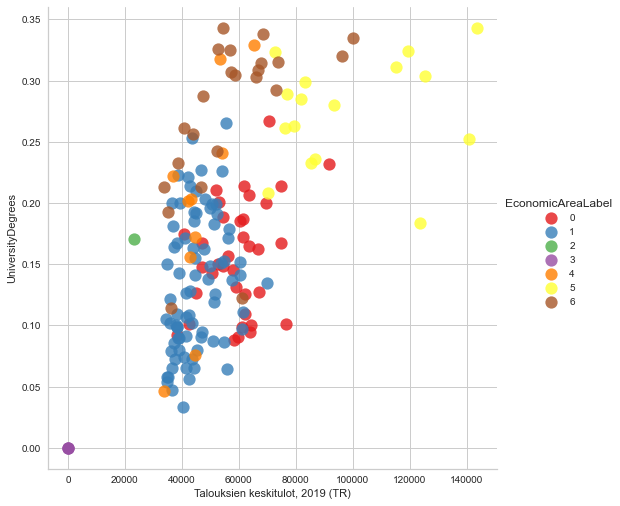

In [17]:
# Plot household mean income vs. university degrees

facet = sns.lmplot(height=7, aspect=1.0,data=postalareas_cluster_df, x='Talouksien keskitulot, 2019 (TR)', y='UniversityDegrees', hue='EconomicAreaLabel',scatter_kws={"s": 150}, fit_reg=False, legend=True, legend_out=True, palette=palette)

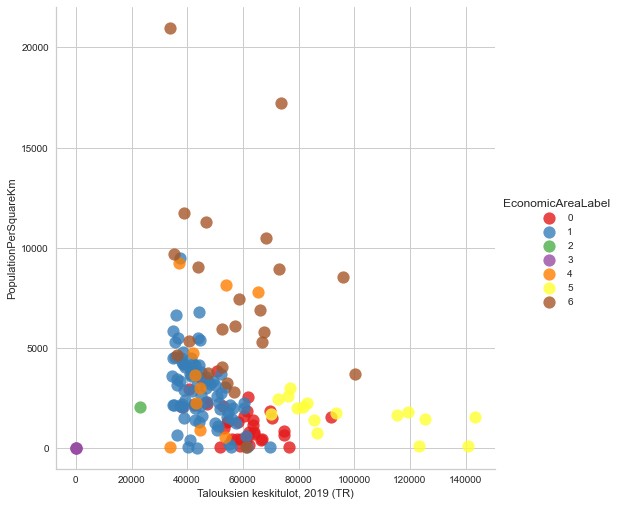

In [18]:
# Plot household mean income vs. population density

facet = sns.lmplot(height=7, aspect=1.0,data=postalareas_cluster_df, x='Talouksien keskitulot, 2019 (TR)', y='PopulationPerSquareKm', hue='EconomicAreaLabel',scatter_kws={"s": 150}, fit_reg=False, legend=True, legend_out=True, palette=palette)

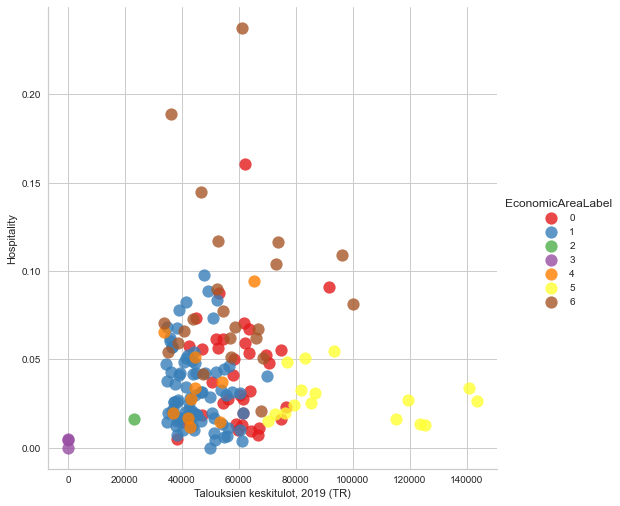

In [19]:
facetgrid = sns.lmplot(data=postalareas_cluster_df,height=7, aspect=1.0, x="Talouksien keskitulot, 2019 (TR)", y="Hospitality", hue='EconomicAreaLabel', scatter_kws={"s": 150}, fit_reg=False, legend=True, legend_out=True,  palette=palette)

In [20]:
# Based on this data we can give names to the area clusters
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 0, 'EconomicArea'] = 'Low density, ManyChildren, Young'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 1, 'EconomicArea'] = 'LowIncome, Older, No University degrees'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 2, 'EconomicArea'] = 'Lowest income, No children'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 3, 'EconomicArea'] = 'No population'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 4, 'EconomicArea'] = 'Low income, various other factors'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 5, 'EconomicArea'] = 'High income, University degrees, Low density'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 6, 'EconomicArea'] = 'Middle income, University degrees, High density'

postalareas_cluster_df.head(10)

EconomicAreaLabel  Talouksien keskitulot, 2019 (TR)  \
0                  4                             65379   
1                  6                             73655   
2                  6                            100200   
3                  6                             96156   
4                  6                             66032   
5                  6                             72867   
6                  6                             68310   
7                  4                             53916   
8                  0                             53083   
9                  6                             57131   

   Työpaikat yhteensä, 2018 (TP)  PopulationPerSquareKm  PopulationAge  \
0                          51915            7790.834742             41   
1                           7553           17245.960243             41   
2                          12142            3687.989556             41   
3                           2673            8540.083555             42   
4                           5428            6889.349154             40   
5                           3482            8929.363413             44   
6                           9644           10498.455862             41   
7                          22164            8124.276419             40   
8                            445             977.762440             37   
9                           2266            6071.540646             40   

   Students  Pensioners  Children  Hospitality  UniversityDegrees  \
0  0.066587    0.185597  0.100179     0.094327           0.329224   
1  0.058511    0.173579  0.115766     0.116245           0.315126   
2  0.056467    0.174655  0.112935     0.081370           0.335019   
3  0.057947    0.193157  0.124479     0.109241           0.320181   
4  0.056153    0.164518  0.101971     0.062270           0.303079   
5  0.060302    0.262399  0.134149     0.104250           0.292219   
6  0.068712    0.179053  0.118212     0.051016           0.337962   
7  0.061769    0.164479  0.122825     0.037358           0.240885   
8  0.066478    0.142857  0.227723     0.087640           0.200535   
9  0.055447    0.183410  0.146109     0.051633           0.306778   

                                      EconomicArea  
0                Low income, various other factors  
1  Middle income, University degrees, High density  
2  Middle income, University degrees, High density  
3  Middle income, University degrees, High density  
4  Middle income, University degrees, High density  
5  Middle income, University degrees, High density  
6  Middle income, University degrees, High density  
7                Low income, various other factors  
8                 Low density, ManyChildren, Young  
9  Middle income, University degrees, High density

In [21]:
# We want to show the area 6 on the map, which is high density, more university degrees, generally medium income. 
postalareas_df['EconomicAreaLabel'] = postalareas_cluster_df['EconomicAreaLabel']
postalareas_df.loc[postalareas_df['EconomicAreaLabel'] == 6, 'MapLabel'] = 1
postalareas_df.loc[postalareas_df['EconomicAreaLabel'] != 6, 'MapLabel'] = 0

In [22]:

map_helsinki = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11.5,tiles="cartodbpositron")

map_helsinki.choropleth(
    geo_data=areas_geo,
    key_on='feature.properties.name',
    data=postalareas_df,
    columns=["Postalcode", "MapLabel"],
    fill_color='PuBuGn', 
    fill_opacity=0.8, 
    line_opacity=0.3,
    legend_name='Postal code areas',
    smooth_factor=0,
    reset=True
    )

map_helsinki



In [23]:
# Let's include foursquare API configuration
import config as cfg

CLIENT_ID = cfg.foursquare['CLIENT_ID']
CLIENT_SECRET = cfg.foursquare['CLIENT_SECRET']
VERSION = cfg.foursquare['VERSION']
LIMIT = 100

FOOD_CATEGORY = "4d4b7105d754a06374d81259"

CATEGORIES = FOOD_CATEGORY

In [24]:
import requests
import json

def getNearbyVenues(postalcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for postalcode, lat, lng in zip(postalcodes, latitudes, longitudes):
        postalcode = str(postalcode)
        lat = str(lat)
        lng = str(lng)
        #print(postalcode + " " + lat + "," + lng)

        '''
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            CATEGORIES,
            LIMIT)
            
        # make the GET request
        json_res = requests.get(url).json()
        json_res
        
        f = open("data/venues_" + postalcode + ".txt", "w")
        json.dump(json_res,f)
        '''
        
        # The same here, during development to make things more reliable the resulting JSON was saved into a file for each neighborhood
        #
        # To fetch the data from Foursquare just uncomment the above code block and comment out the following 3 lines
        #
        f = open("data/venues_" + postalcode + ".txt", "r")
        json_res = json.load(f)
        f.close()

        #print( "json_res: " + str(json_res))

        results = json_res["response"]['groups'][0]['items']
        #print("results: " + str(results))
        

        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postalcode', 
                'Postalcode Latitude', 
                'Postalcode Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']
    
    return(nearby_venues)

In [25]:

# Let's grab the data we need to get the venue data
temp_df = postalareas_df[['Postalcode','latitude','longitude']]

postal_code_list = temp_df['Postalcode'].to_list()
latitude_list = temp_df['latitude'].to_list()
longitude_list = temp_df['longitude'].to_list()

nearby_venues_df = getNearbyVenues(postal_code_list,latitude_list,longitude_list)

nearby_venues_df.head(5)

Postalcode Postalcode Latitude Postalcode Longitude                   Venue  \
0      00100   60.17189939106672   24.926875389936413            Ateljé Finne   
1      00100   60.17189939106672   24.926875389936413            Young Hearts   
2      00100   60.17189939106672   24.926875389936413  Twisted Street Kitchen   
3      00100   60.17189939106672   24.926875389936413                  Fafa's   
4      00100   60.17189939106672   24.926875389936413                  Levain   

   Venue Latitude  Venue Longitude           Venue Category  
0       60.171198        24.928515  Scandinavian Restaurant  
1       60.171353        24.926107               Restaurant  
2       60.170641        24.928203         Asian Restaurant  
3       60.169876        24.927835       Falafel Restaurant  
4       60.173094        24.923056                   Bakery

In [26]:
# one hot encoding
venues_onehot = pd.get_dummies(nearby_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
venues_onehot['Postalcode'] = nearby_venues_df['Postalcode'] 

# move postal code column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot

Postalcode  American Restaurant  Arepa Restaurant  Asian Restaurant  \
0         00100                    0                 0                 0   
1         00100                    0                 0                 0   
2         00100                    0                 0                 1   
3         00100                    0                 0                 0   
4         00100                    0                 0                 0   
...         ...                  ...               ...               ...   
1279      02770                    0                 0                 0   
1280      02780                    0                 0                 0   
1281      02780                    0                 0                 0   
1282      02820                    0                 0                 0   
1283      02920                    0                 0                 0   

      BBQ Joint  Bagel Shop  Bakery  Belgian Restaurant  Bistro  \
0             0           0       0                   0       0   
1             0           0       0                   0       0   
2             0           0       0                   0       0   
3             0           0       0                   0       0   
4             0           0       1                   0       0   
...         ...         ...     ...                 ...     ...   
1279          0           0       0                   0       0   
1280          0           0       0                   0       0   
1281          0           0       0                   0       0   
1282          0           0       0                   0       0   
1283          0           0       0                   0       0   

      Brazilian Restaurant  ...  Taco Place  Tapas Restaurant  \
0                        0  ...           0                 0   
1                        0  ...           0                 0   
2                        0  ...           0                 0   
3                        0  ...           0                 0   
4                        0  ...           0                 0   
...                    ...  ...         ...               ...   
1279                     0  ...           0                 0   
1280                     0  ...           0                 0   
1281                     0  ...           0                 0   
1282                     0  ...           0                 0   
1283                     0  ...           0                 0   

      Thai Restaurant  Theme Restaurant  Tibetan Restaurant  \
0                   0                 0                   0   
1                   0                 0                   0   
2                   0                 0                   0   
3                   0                 0                   0   
4                   0                 0                   0   
...               ...               ...                 ...   
1279                0                 0                   0   
1280                0                 0                   0   
1281                0                 0                   0   
1282                0                 0                   0   
1283                0                 0                   0   

      Turkish Restaurant  Vegetarian / Vegan Restaurant  \
0                      0                              0   
1                      0                              0   
2                      0                              0   
3                      0                              0   
4                      0                              0   
...                  ...                            ...   
1279                   0                              0   
1280                   0                              0   
1281                   0                              0   
1282                   0                              0   
1283                   0                              0   

      Venezuelan Restaurant  Vietnamese 

In [27]:
venues_onehot_grouped = venues_onehot.groupby('Postalcode').mean().reset_index()
venues_onehot_grouped

Postalcode  American Restaurant  Arepa Restaurant  Asian Restaurant  \
0        00100             0.000000               0.0          0.029412   
1        00120             0.020000               0.0          0.010000   
2        00130             0.052632               0.0          0.026316   
3        00140             0.000000               0.0          0.000000   
4        00150             0.000000               0.0          0.000000   
..         ...                  ...               ...               ...   
131      02760             0.000000               0.0          0.000000   
132      02770             0.000000               0.0          0.000000   
133      02780             0.000000               0.0          0.000000   
134      02820             0.000000               0.0          0.000000   
135      02920             0.000000               0.0          0.000000   

     BBQ Joint  Bagel Shop    Bakery  Belgian Restaurant    Bistro  \
0          0.0        0.00  0.058824                 0.0  0.000000   
1          0.0        0.01  0.050000                 0.0  0.000000   
2          0.0        0.00  0.000000                 0.0  0.026316   
3          0.0        0.00  0.055556                 0.0  0.055556   
4          0.0        0.00  0.000000                 0.0  0.100000   
..         ...         ...       ...                 ...       ...   
131        0.0        0.00  1.000000                 0.0  0.000000   
132        0.0        0.00  0.000000                 0.0  0.000000   
133        0.0        0.00  0.000000                 0.0  0.000000   
134        0.0        0.00  0.000000                 0.0  0.000000   
135        0.0        0.00  0.000000                 0.0  0.000000   

     Brazilian Restaurant  ...  Taco Place  Tapas Restaurant  Thai Restaurant  \
0                     0.0  ...    0.029412               0.0         0.000000   
1                     0.0  ...    0.000000               0.0         0.020000   
2                     0.0  ...    0.000000               0.0         0.000000   
3                     0.0  ...    0.000000               0.0         0.055556   
4                     0.0  ...    0.000000               0.0         0.000000   
..                    ...  ...         ...               ...              ...   
131                   0.0  ...    0.000000               0.0         0.000000   
132                   0.0  ...    0.000000               0.0         0.000000   
133                   0.0  ...    0.000000               0.0         0.000000   
134                   0.0  ...    0.000000               0.0         0.000000   
135                   0.0  ...    0.000000               0.0         0.000000   

     Theme Restaurant  Tibetan Restaurant  Turkish Restaurant  \
0                0.00                 0.0                0.00   
1                0.01                 0.0                0.01   
2                0.00                 0.0                0.00   
3                0.00                 0.0                0.00   
4                0.00                 0.0                0.10   
..                ...                 ...                 ...   
131              0.00                 0.0                0.00   
132              0.00                 0.0                0.00   
133              0.00                 0.0                0.00   
134              0.00                 0.0                0.00   
135              0.00                 0.0                0.00   

     Vegetarian / Vegan Restaurant  Venezuelan Restaurant  \
0                         0.000000                    0.0   
1                         0.030000                    0.0   
2                         0.078947                    0.0   
3                         0.000000                    0.0   
4                         0.000000                    0.0   
..                             ...                    ...   
131                       0.000000                    0.0   
132                 

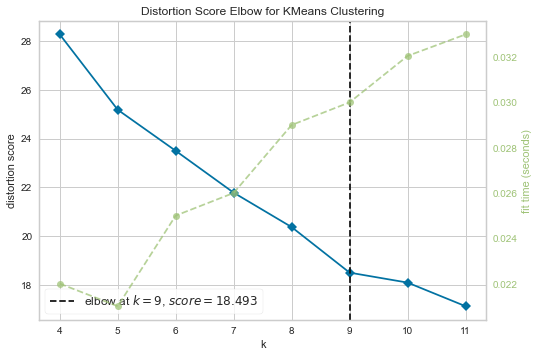

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Let's drop the Neighborhood column before feeding the dataframe into KMeans
venues_grouped_clustering = venues_onehot_grouped.drop('Postalcode', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(venues_grouped_clustering)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# So based on this the optimal k would be 9

In [29]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 9

# Let's drop the Neighborhood column before feeding the dataframe into KMeans
venues_grouped_clustering = venues_onehot_grouped.drop('Postalcode', 1)

# Train k-means clustering model
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0])

In [30]:

# Let's try to see the qualities of the venue areas with parallel coordinates chart

venues_onehot_grouped_temp = venues_onehot_grouped
venues_onehot_grouped_temp['VenueLabels'] = kmeans.labels_
venues_onehot_grouped_temp = venues_onehot_grouped_temp.groupby('VenueLabels').mean().reset_index()

# Let's select only the most often occurring venue types
venues_onehot_grouped_temp = venues_onehot_grouped_temp.loc[:,venues_onehot_grouped_temp.sum() > 0.05]
venues_onehot_grouped_temp.head(9)



VenueLabels  Asian Restaurant  BBQ Joint    Bakery  Breakfast Spot  \
0            0          0.006410   0.000000  0.035256        0.000000   
1            1          0.024537   0.017808  0.037988        0.012123   
2            2          0.000000   0.000000  0.000000        0.000000   
3            3          0.000000   0.038462  0.000000        0.000000   
4            4          0.000000   0.000000  0.000000        0.000000   
5            5          0.000000   0.000000  0.000000        0.000000   
6            6          0.000000   0.000000  0.000000        0.000000   
7            7          0.066667   0.000000  0.613333        0.100000   
8            8          0.000000   0.000000  0.000000        0.000000   

     Buffet  Burger Joint  Cafeteria      Café  Chinese Restaurant  ...  \
0  0.000000      0.028846   0.042949  0.088187            0.033806  ...   
1  0.012894      0.019957   0.044835  0.125848            0.042086  ...   
2  0.050000      0.000000   0.000000  0.000000            0.000000  ...   
3  0.000000      0.000000   0.025148  0.700761            0.000000  ...   
4  0.000000      0.000000   0.000000  0.000000            0.000000  ...   
5  0.000000      0.000000   0.000000  0.000000            0.000000  ...   
6  0.062500      0.031250   0.000000  0.031250            0.000000  ...   
7  0.040000      0.000000   0.000000  0.000000            0.000000  ...   
8  0.040816      0.000000   0.526531  0.086054            0.000000  ...   

   Italian Restaurant  Kebab Restaurant  Mexican Restaurant  Pizza Place  \
0            0.007692          0.012821             0.00000     0.480784   
1            0.022574          0.014087             0.00822     0.104586   
2            0.000000          0.000000             0.00000     0.050000   
3            0.025148          0.000000             0.00000     0.030220   
4            0.000000          0.000000             0.00000     1.000000   
5            0.000000          0.000000             0.00000     0.000000   
6            0.000000          0.000000             0.06250     0.031250   
7            0.000000          0.040000             0.00000     0.100000   
8            0.000000          0.000000             0.00000     0.157483   

   Restaurant  Sandwich Place  Scandinavian Restaurant  Snack Place  \
0    0.065812        0.041667                 0.009615     0.000000   
1    0.061293        0.019962                 0.047534     0.006283   
2    0.000000        0.000000                 0.000000     0.100000   
3    0.055368        0.025148                 0.016906     0.000000   
4    0.000000        0.000000                 0.000000     0.000000   
5    0.000000        0.000000                 0.000000     0.000000   
6    0.687500        0.000000                 0.000000     0.062500   
7    0.000000        0.000000                 0.000000     0.000000   
8    0.019048        0.029932                 0.000000     0.000000   

   Sushi Restaurant  Thai Restaurant  
0          0.020513         0.000000  
1          0.031729         0.014775  
2          0.000000         0.000000  
3          0.000000         0.000000  
4          0.000000         0.000000  
5          0.000000         0.000000  
6          0.000000         0.000000  
7          0.000000         0.040000  
8          0.009524         0.000000  

[9 rows x 24 columns]

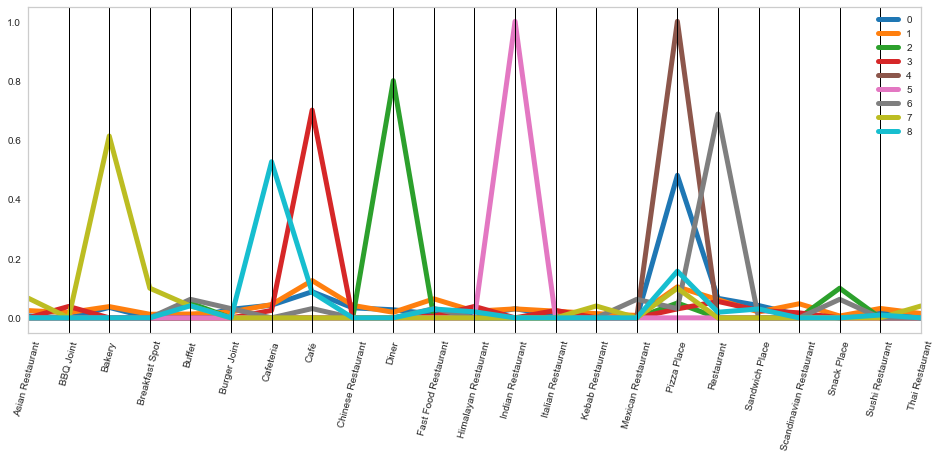

In [31]:
fig, ax = plt.subplots(figsize=(16,6))
plt.xticks(rotation = 75)
pd.plotting.parallel_coordinates(venues_onehot_grouped_temp,class_column='VenueLabels',colormap='tab10',lw=5)
plt.show()

# Based on this we can give names to the venue clusters:

# 0: Pizza, cafes, sandwich
# 1: Variety of cafes, fast food, pizza, restaurants
# 2: Diners, Snack
# 3: Cafes
# 4: Only pizza
# 5: Indian food
# 6: Generic restaurants
# 7: Bakeries and pizza
# 8: Cafeterias

In [32]:
# Let's create a new merged dataframe which will include cluster labels and lat&long information as well.

df_venue_clusters = postalareas_df[['Postalcode','Areaname','latitude','longitude']]
#df_venue_clusters

# Let's create cluster labels df
venues_clusters = venues_onehot_grouped[['Postalcode']]
venues_clusters.insert(0, 'VenueLabels', kmeans.labels_)

# Let's merge dataframes to add latitude/longitude for each neighborhood
df_merged = df_venue_clusters.join(venues_clusters.set_index('Postalcode'), on='Postalcode')
df_merged['VenueLabels'] = df_merged['VenueLabels'].fillna(-1)
df_merged['VenueLabels'] = df_merged['VenueLabels'].astype(int)
df_merged
#df_venue_clusters2 = df_venue_clusters.join(venues_onehot_grouped.set_index('Postalcode'), on='Postalcode')
#df_venue_clusters2
#df_merged.head(10)
#postalareas_df.head()

# So now finally we have venue clusters for all postal codes, with some postal codes being without cluster


Postalcode                        Areaname   latitude  longitude  \
0        00100   Helsinki Keskusta - Etu-Töölö  60.171899  24.926875   
1        00120                       Punavuori  60.163736  24.937339   
2        00130                 Kaartinkaupunki  60.164295  24.950154   
3        00140        Kaivopuisto - Ullanlinna  60.157983  24.953251   
4        00150               Eira - Hernesaari  60.154157  24.934137   
..         ...                             ...        ...        ...   
163      02860                      Siikajärvi  60.284217  24.512485   
164      02920                        Niipperi  60.273161  24.739158   
165      02940           Lippajärvi-Järvenperä  60.260066  24.697941   
166      02970                       Kalajärvi  60.325323  24.716658   
167      02980                         Lakisto  60.332766  24.625167   

     VenueLabels  
0              1  
1              1  
2              1  
3              1  
4              1  
..           ...  
163           -1  
164            6  
165           -1  
166           -1  
167           -1  

[168 rows x 5 columns]

In [33]:
import matplotlib.cm as cm
import matplotlib.colors as colors

cluster_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, poi, cluster in zip(df_merged['latitude'], df_merged['longitude'], df_merged['Postalcode'], df_merged['VenueLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=11,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
    
cluster_map

### Getting to conclusion

Based on the discussions with the owners of the Good coffee company it has been found that they would like to find a place with relatively high
population density that would have good purchasing power and also an existing variety of food and hospitability related venues. 

We can find this type of areas by creating an intersection of the economic cluster 6 and venue cluster 1.

In [34]:
#postalareas_df
df_conclusion = df_merged
df_conclusion['EconomicLabels'] = postalareas_df['EconomicAreaLabel']
#df_conclusion

df_temp = df_conclusion.loc[df_conclusion['EconomicLabels'] == 6]
df_temp = df_temp.loc[df_temp['VenueLabels'] == 1]

# So this dataframe contains the intersection we wanted, let's plot it on a map
df_temp.head()

Postalcode                   Areaname   latitude  longitude  VenueLabels  \
1      00120                  Punavuori  60.163736  24.937339            1   
2      00130            Kaartinkaupunki  60.164295  24.950154            1   
3      00140   Kaivopuisto - Ullanlinna  60.157983  24.953251            1   
4      00150          Eira - Hernesaari  60.154157  24.934137            1   
5      00160                Katajanokka  60.166368  24.969330            1   

   EconomicLabels  
1               6  
2               6  
3               6  
4               6  
5               6

In [35]:
map_helsinki = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11.5,tiles="cartodbpositron")

#df_temp = asda_df.replace('Postalcode')

map_helsinki.choropleth(
    geo_data=areas_geo,
    key_on='feature.properties.name',
    data=df_temp,
    columns=["Postalcode", "VenueLabels"],
    fill_color="Greens", 
    fill_opacity=0.5, 
    line_opacity=0.3,
    legend_name='Postal code areas',
    smooth_factor=0,
    reset=True
    )

map_helsinki
